In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load images
def load_images(folder, label):
    images = []
    labels = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (128, 128))  # Resize
        img = img.flatten() / 255.0  # Normalize and flatten
        images.append(img)
        labels.append(label)
    return images, labels

In [5]:
# Load dataset
dogs, dog_labels = load_images("cats_and_dogs_filtered/train/dogs", 0)
cats, cat_labels = load_images("cats_and_dogs_filtered/train/cats", 1)

In [7]:
# Prepare dataset
X = np.array(dogs + cats)
y = np.array(dog_labels + cat_labels)

In [9]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Train SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
# Predictions
y_pred = svm_model.predict(X_test)

In [15]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4725
              precision    recall  f1-score   support

           0       0.46      0.39      0.43       199
           1       0.48      0.55      0.51       201

    accuracy                           0.47       400
   macro avg       0.47      0.47      0.47       400
weighted avg       0.47      0.47      0.47       400



In [33]:
from skimage.feature import hog
from skimage.color import rgb2gray

# Function to extract HOG features from an image
def extract_hog_features(image_path):
    img = cv2.imread(image_path)  # Read image
    if img is None:
        print(f"Warning: Could not read {image_path}")  # Handle missing images
        return None
    img_gray = rgb2gray(img)  # Convert to grayscale
    img_resized = cv2.resize(img_gray, (256, 256))  # Resize image
    hog_features = hog(img_resized, 
                       pixels_per_cell=(8, 8), 
                       cells_per_block=(2, 2), 
                       feature_vector=True)
    return hog_features

# Folder paths for cats and dogs images
cat_folder = "cats_and_dogs_filtered/train/cats"
dog_folder = "cats_and_dogs_filtered/train/dogs"

In [35]:
# Load image paths and labels
image_paths = []
labels = []  # 0 for Cat, 1 for Dog

# Load cat images
for img_file in os.listdir(cat_folder):
    img_path = os.path.join(cat_folder, img_file)
    image_paths.append(img_path)
    labels.append(0)  # Cat label

# Load dog images
for img_file in os.listdir(dog_folder):
    img_path = os.path.join(dog_folder, img_file)
    image_paths.append(img_path)
    labels.append(1)  # Dog label

# Extract HOG features for all images
hog_features_list = []
valid_labels = []  # To track valid labels

for img_path, label in zip(image_paths, labels):
    features = extract_hog_features(img_path)
    if features is not None:  # Only add valid features
        hog_features_list.append(features)
        valid_labels.append(label)

# Convert to NumPy arrays
hog_features_array = np.array(hog_features_list)
labels_array = np.array(valid_labels)

print(f"HOG Features Shape: {hog_features_array.shape}")
print(f"Labels Shape: {labels_array.shape}")

HOG Features Shape: (2000, 34596)
Labels Shape: (2000,)


In [37]:
# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(hog_features_array, labels_array, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data: {X_test.shape}, Labels: {y_test.shape}")

Training Data: (1600, 34596), Labels: (1600,)
Testing Data: (400, 34596), Labels: (400,)


In [43]:
from sklearn.preprocessing import StandardScaler

# Standardize features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVM classifier
svm_model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)

svm_model.fit(X_train_scaled, y_train)

print("SVM Model Trained Successfully!")

SVM Model Trained Successfully!


In [45]:
# Predictions on test set
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.7575
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       199
           1       0.77      0.74      0.75       201

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400



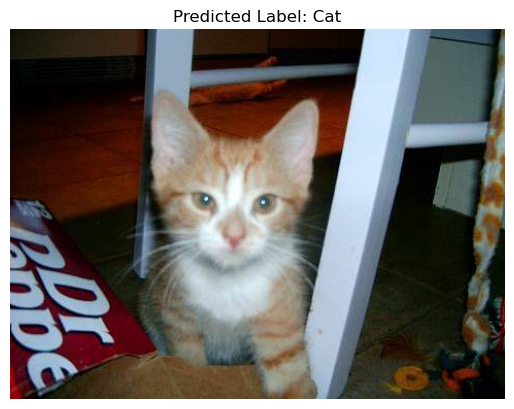

In [69]:
import matplotlib.pyplot as plt
# Function to predict and display the image
def predict_and_show(image_path, model):
    hog_features = extract_hog_features(image_path)  # Extract HOG features
    if hog_features is None:  # Handle failed feature extraction
        print(f"Skipping {image_path} due to feature extraction failure.")
        return

    hog_features = np.array(hog_features).reshape(1, -1)  # Reshape for model

    # Ensure feature size matches model input
    if hog_features.shape[1] != model.n_features_in_:
        print(f"Feature size mismatch! Model expects {model.n_features_in_}, but got {hog_features.shape[1]}")
        return

    prediction = model.predict(hog_features)  # Predict using trained model
    label = "Dog" if prediction[0] == 1 else "Cat"  # Convert prediction to label

    # Display the image
    img = cv2.imread(image_path)[:, :, ::-1]  # Convert BGR to RGB for proper display
    plt.imshow(img)
    plt.title(f"Predicted Label: {label}")
    plt.axis("off")
    plt.show()

# Example usage (pass the path of a test image)
test_image_path = "cats_and_dogs_filtered/cat.9827.jpg"  # Update with actual image path
predict_and_show(test_image_path, svm_model)

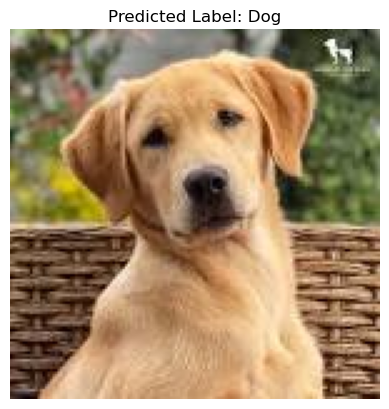

In [71]:
# Example usage (pass the path of a test image)
test_image_path = "cats_and_dogs_filtered/dog.jpeg"  # Update with actual image path
predict_and_show(test_image_path, svm_model)